# Quantitative Macroeconomics - Homework III
Ivana Kaloyanova Ganeva

*October 23, 2020*

SOME NOTES FROM THE TA SESSION
- recursive formulation:
    - we solve the HH problem for all possible states (on capital...)
    - state variables (s=k): decide the situation of the households in t
        - endogenous state var: k
        - exogenous state var: shock
    - choice variables: k', h, c
        - $g^z$, $g^c(k)$
    - Bellmann equation:
        - $V(s) = \max_{g^z} \{u(c,l) + \beta\mathbb{E}[v(s')]\}$
        - s.t. $F(g^z,\theta)\geq 0 $
    - The solution of this problem is a set of unique functinons
        - $[v'(k), g^c(k), g^{k'}(k), g^h(k)]'$
        - All methods must lead to the same solution
- Main Standard Solution Methods:
    - VFI: we iterate on $v(k)$ through the Bellman equation $v^{j+1}(k) = T(v^j(k))$
        - in discrete
        - continuous
    - Policy function iteration (Discrete or Continuous)
        - time_iter
        - FOC_iter
        - 'Policy iteration': we iterate our policy functions through the FOC
            - $V_c(c(s)) = \beta(1+r)\mathbb{E}[V_c(c(s'))]$
            - first guess could be: $k'=k$
    - VFI vs. FOC iteration
        - Adv. + Robust
        - + Speed
        - + Accuracy
        - Because in the int. decreases (Bellman equation argument)
    - VFI discrete vs. continuous

In [15]:
# Preliminary to the preliminaries if package quantecon is missing:
# pip install quantecon

In [14]:
# SOME PRELIMINARIES:
# (loading the necessary libraries)
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import quantecon as qe
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
np.seterr(divide = 'ignore', invalid = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Qustion 1. Value Function Iteration
Considering a stationary economy populated by a large number of identical infinitely-lived households that maximize:
\begin{equation}
    \mathbb{E}_{0}\left\{\sum_{t=0}^{\infty} \beta^t u(c,h_t) \right\}
\end{equation}
over consumption and leisure, subject to:
\begin{align}
    c_t + i_t &= y_t\\
    y_t &= k_t^{1-\theta}h_t^{\theta}\\
    i_t &= k_{t+1} - (1-\delta)k_t \, ,
\end{align}
where we the utility function is given by: $u(c_t, 1-h_t) = \log{c_t} - \kappa\dfrac{h_t^{1+\frac{1}{\nu}}}{1+\frac{1}{\nu}}$, and we set the parameters at:
\begin{align}
    \theta &= 0.679\\
    \beta &= 0.988\\
    \delta &= 0.013
\end{align}
as required. We begin with a set up where labour supply is inelastic at $h_t = 1$, and for the sake of computing the steady-state, we normalize output to 1.

### 1. Posing the Recursive Formulation of the Sequential Problem Without Productivity Shocks
*As required, I will discretize the state space and the value function, and will proceed to solve for it under the computational variants listed below. In all different set-ups, I will use the same initial guess for the value function in order to facilitate comparison.*

In [53]:
# Setting the parameter values:
theta = 0.679
beta = 0.988
delta = 0.013
nu = 2.0
kappa = 5.24

# Initially inelastic labor supply:
h = 1

#### (a) Solving with Brute Force Iterations of the Value Function
*Here, I will be closely following the steps presented in our lectures.*

I begin by simplifying slightly the problem by performing manipulations similar to the ones in the previous project. That is, I will once again combine all the three constraints into one (since they are binding), so that the identical households maximize
\begin{equation*}
V(k) = u(k^{1-\theta} + (1-\delta)k - k') + \beta\cdot V(k')
\end{equation*}
on $k'\,\in\,\Gamma(k)$ subject to $\Gamma(k) = \{k'\,\in\,[0, k^{1-\theta}+(1-\delta)k]\}$.

In [126]:
# STEP 1: Discretizing the state space
# - here, the continuous variable of k is discretized and the state space is thus turned into a grid of n points:
# ------ K = {k1, k2, ... , kn} ,
# ------ where k1 = 0.1      -> not 0 so to avoid zero consumption/output issues, as suggested in class
# ------ and   kp = 1.5*k_ss -> this is the steady state capital level, increased by half
# ----------- (supposing we are interested in the dynamics below the steady state)

# Setting the minimal k:
k1 = 0.1
# Recall:
k_ss = ((1/beta + delta - 1)/(1-theta))**(-1/theta)
# Hence,:
kn = 1.5*k_ss

# Setting the number of grid points:
n = 200

# Generating the grid for the discretized capital:
k = np.linspace(k1, kn, n)


# _______________________________________________________________________
# STEP 2: Guessing a solution
# - here, as suggested in class, the initial guess will be the zero vector:

V = np.zeros((1,n))


# _______________________________________________________________________
# STEP 3: Defining the return matrix M
# - that is, the feasible return matrix, where consumption is ensured to be non-negative for all combinations of
# - capital levels (k,k'):

M = np.zeros((n,n)) # initializing


# _______________________________________________________________________
# STEP 4: Filling the return matrix M appropriately
# - that is, since not all consumption/capital tomorrow values are feasible, we 'fix' the negative consumption
# - issue by setting the appropriate elements of M to a very negative number (in my case, I've chosen -10k)
# ------- this ensures that these entries won't be considered to be the optimal solution,
# ------- i.e. optimality will for sure be also feasible, as we want it to be

for i in range(n):  # filling the matrix
    for j in range(n):
        if (k[i]**(1-theta) + (1-delta)*k[i] - k[j]) >= 0:
            M[i][j] = np.log(k[i]**(1-theta) + k[i]*(1-delta) - k[j]) - (kappa/(1+nu**(-1)))
        else:
            M[i][j] = -10000                                                          

                                                                         
# _______________________________________________________________________
# STEPS 5&6: Value function iteration and convergence criterion
# - as described in the lecture slides
                                                                         
# Setting the convergence tolerance here:
eps = 0.01

# Building the function:
def ValueFunction(V,M):
    X = np.zeros((n,n))    # initializing X
    g = np.zeros((1,n))    # initializing g
    V_pr = np.zeros((1,n)) # initializing the V' - i.e. the new iteration on V
    
    # STARTING THE TIMER FOR TIME EXECUTION:
    qe.tic()

    for i in range(n):     # filling X
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    for i in range(n):     # filling V'
        V_pr[0][i] = np.amax(X[i][:]) # that is the maximum element of every (respective)row in X
        g[0][i] = np.argmax(X[i][:])  # that is the argmax, i.e. 'location' of maximum element extracted above
        
    cntr = 0            # setting a counter for the iterations required to reach a convergence
    
    while np.any(abs(V - V_pr) >= eps): # this is the convergence criterion, i.e. 'do this while distance is larger'
        V = V_pr.copy()    # new iteration now becomes the 'old' iteration
        for i in range(n):
            for j in range(n):
                X[i][j] = M[i][j] + beta*V_pr[0][j]
        for i in range(n):
            V_pr[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])
        cntr += 1
 
    time = qe.toc()
    time = round(time, 2)
    
    VF = np.transpose(V)
    
    print(str(cntr) + ' iterations required to obtain convergence')
    print('Time elapsed for execution: ' + str(time) + ' seconds')
    
    return [VF, g]

# Value function obtained from function above:
brute_force = ValueFunction(V,M)
vf_br_f = brute_force[0]
g_br_f = brute_force[1]

TOC: Elapsed: 0:00:14.02
462 iterations required to obtain convergence
Time elapsed for execution: 14.03 seconds


Here, the brute force method requires 462 iterations and takes quite long - about 14 seconds (on my computer). Naturally, when one allows for certain properties in the above code, time elapsed should be significantly less.

Below, I will conclude this part by plotting the value and policy functions obtained.

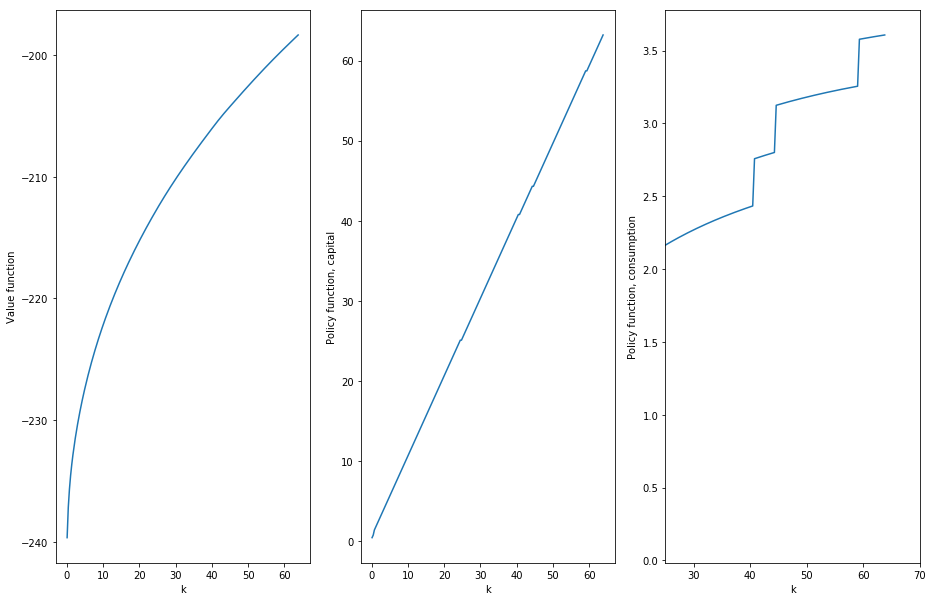

In [128]:
# Obtaining the policy functions:
g_capital = np.zeros(n) # initialization
g_cons = np.zeros(n)

g_br_f = g_br_f.reshape((200,))

for i in range(n):
    g_capital[i] = k[int(g_br_f[i])]
    g_cons[i] = k[i]**(1-theta) + (1-delta)*k[i] - g_capital[i]
    
vf_br_f = vf_br_f.reshape((200,))
    
# Plotting:
plt.figure()
# Value function
plt.subplot(131)
plt.plot(k, vf_br_f, label = 'V(k)')  
plt.xlabel('k')
plt.ylabel('Value function')
# Policy - capital (trivial)
plt.subplot(132)
plt.plot(k, g_capital, label = '$g_k$')  
plt.xlabel('k')
plt.ylabel('Policy function, capital')
# Policy - consumption
plt.subplot(133)
plt.plot(k, g_cons, label = '$g_c$')  
plt.xlabel('k')
plt.xlim(25,70)
plt.ylabel('Policy function, consumption')

plt.subplots_adjust(top = 2, bottom = 0.08, left = 0, right = 2, hspace = 0.3, wspace = 0.2)

plt.show()

#### (b) Accounting for the Monotonicity of the Optimal Decision Rule
*Notice that the first four steps of the above algortithm remain absolutely the same as the only changes required are located within the ValueFunction definition part of the code. The significant change here is that there is a lower bound to the decision rule - i.e. a lower bound condition imposed on the $\chi$ matrix.*

In [129]:
# Re-building the function:
def ValueFunction2(V,M):
    X = np.zeros((n,n))    # initializing X
    g = np.zeros((1,n))    # initializing g
    V_pr = np.zeros((1,n)) # initializing the V' - i.e. the new iteration on V
    
    # STARTING THE TIMER FOR TIME EXECUTION:
    qe.tic()

    for i in range(n):     # filling X
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    for i in range(n):     # filling V'
        V_pr[0][i] = np.amax(X[i][:]) # that is the maximum element of every (respective)row in X
        g[0][i] = np.argmax(X[i][:])  # that is the argmax, i.e. 'location' of maximum element extracted above
        
    cntr = 0            # setting a counter for the iterations required to reach a convergence
    
    while np.any(abs(V - V_pr) >= eps): # this is the convergence criterion, i.e. 'do this while distance is larger'
        V = V_pr.copy()    # new iteration now becomes the 'old' iteration
        X = np.ones((n,n))*(-1000)      # this is the lower bound definition's beginning
        for i in range(n):
            search = np.int_(np.linspace(np.int_(g[0][i]), n-1, n-np.int_(g[0][i])))
            for j in search:
                X[i][j] = M[i][j] + beta*V_pr[0][j] # only calculating the relevant entries using the lower bound
        for i in range(n):
            V_pr[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])
        cntr += 1
 
    time = qe.toc()
    time = round(time, 2)
    
    VF = np.transpose(V)
    
    print(str(cntr) + ' iterations required to obtain convergence')
    print('Time elapsed for execution: ' + str(time) + ' seconds')
    
    return [VF, g]

# Value function obtained from function above:
monotonicity = ValueFunction2(V,M)
vf_m = monotonicity[0]
g_m = monotonicity[1]

TOC: Elapsed: 0:00:10.28
462 iterations required to obtain convergence
Time elapsed for execution: 10.28 seconds


Here, the method requires 462 iterations again, but time is sufficiently decreased by almost 4 seconds (on my computer), or, to be precise, by 26.7% at 10.28 seconds.

Below, I will conclude this part by plotting the value and policy functions obtained. They will remain the same, since the required number of iterations for convergence is the same (naturally), and only time has improved.

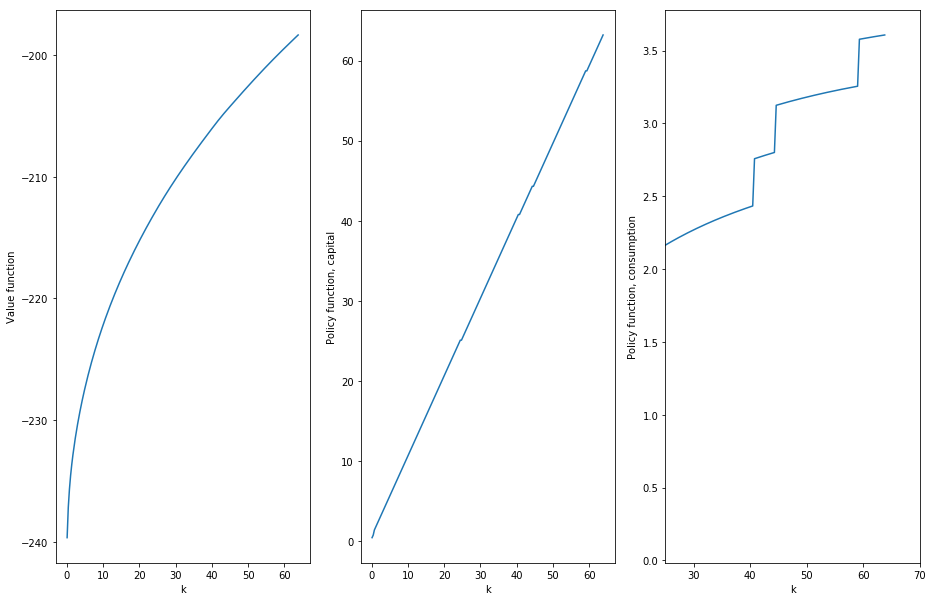

In [130]:
# Obtaining the policy functions:
g_capital = np.zeros(n) # initialization
g_cons = np.zeros(n)

g_m = g_m.reshape((200,))

for i in range(n):
    g_capital[i] = k[int(g_m[i])]
    g_cons[i] = k[i]**(1-theta) + (1-delta)*k[i] - g_capital[i]
    
vf_m = vf_m.reshape((200,))
    
# Plotting:
plt.figure()
# Value function
plt.subplot(131)
plt.plot(k, vf_m, label = 'V(k)')  
plt.xlabel('k')
plt.ylabel('Value function')
# Policy - capital (trivial)
plt.subplot(132)
plt.plot(k, g_capital, label = '$g_k$')  
plt.xlabel('k')
plt.ylabel('Policy function, capital')
# Policy - consumption
plt.subplot(133)
plt.plot(k, g_cons, label = '$g_c$')  
plt.xlabel('k')
plt.xlim(25,70)
plt.ylabel('Policy function, consumption')

plt.subplots_adjust(top = 2, bottom = 0.08, left = 0, right = 2, hspace = 0.3, wspace = 0.2)

plt.show()

#### (c) Accounting for the Concavity of the Value Function
*Notice that, once again, the first four steps of the initial algortithm remain absolutely the same as the only changes required are located within the ValueFunction definition part of the code.*

Concavity of the value function implies that:
\begin{align*}
    M_{i j} + \beta\cdot V_{0 j} < M_{ij-1} + \beta\cdot V_{0j-1} &\Longrightarrow M_{i j+1} + \beta\cdot V_{0 j+1} < M_{ij-1} + \beta\cdot V_{0j-1}\\
    &\Longrightarrow M_{i j+2} + \beta\cdot V_{0 j+2} < M_{ij-1} + \beta\cdot V_{0j-1} \cdots \, .
\end{align*}

Hence, we can omit the computation of the whole $\chi$ matrix and only keep obtaining the elements in a row until we find an element which is smaller than the previous ones in the same row - we are certain that the elements which won't be calculated this time will be smaller, too. That is, the maximum has already been found for sure.

In [135]:
# Re-building the function:
def ValueFunction3(V,M):
    X = np.zeros((n,n))    # initializing X
    g = np.zeros((1,n))    # initializing g
    V_pr = np.zeros((1,n)) # initializing the V' - i.e. the new iteration on V
    
    # STARTING THE TIMER FOR TIME EXECUTION:
    qe.tic()

    cntr = 0            # setting a counter for the iterations required to reach a convergence
    
    while np.any(abs(V - V_pr) >= eps): # this is the convergence criterion, i.e. 'do this while distance is larger'
        for i in range(n):
            for j in range(n):
                X[i][j] = M[i][j] + beta*V[0][j]
                if X[i][j] < X[i][j-1]: # concavity condition described above
                    break
        for i in range(n):
            V_pr[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])
        
        V = np.copy(V_pr)
        V_pr = np.zeros((1,n))
        
        cntr += 1
 
    time = qe.toc()
    time = round(time, 2)
    
    VF = np.transpose(V)
    
    print(str(cntr) + ' iterations required to obtain convergence')
    print('Time elapsed for execution: ' + str(time) + ' seconds')
    
    return [VF, g]

# Value function obtained from function above:
concavity = ValueFunction3(V,M)
vf_c = concavity[0]
g_c = concavity[1]

TOC: Elapsed: 0:00:0.00
0 iterations required to obtain convergence
Time elapsed for execution: 0.0 seconds
